In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('/Users/omniscience/Desktop/project/ML/ing/data/1984-2021_mc.csv')
print(df.shape)
df.head()

(13516, 10)


,YEAR,MO,DY,PS,PRECTOTCORR,T2M,QV2M,ALLSKY_SFC_SW_DWN,WS50M,ALLSKY_SFC_PAR_TOT
0,1984,1,1,74.75,0.17,8.19,4.88,5.26,1.19,98.7
1,1984,1,2,74.68,1.18,7.11,5.31,4.80,2.26,93.7
2,1984,1,3,74.68,1.97,7.11,6.41,3.61,2.53,72.3
3,1984,1,4,74.76,0.13,8.51,6.90,3.57,1.98,71.6
4,1984,1,5,74.75,0.02,10.40,6.84,4.91,1.44,95.5


In [3]:
df['date'] = df['YEAR'].map(str)+"/"+df['MO'].map(str)+"/"+df['DY'].map(str)
pd.to_datetime(df['date'])
df.index = pd.to_datetime(df['date'],format='%Y-%m-%d')
df.index

DatetimeIndex(['1984-01-01', '1984-01-02', '1984-01-03', '1984-01-04',
               '1984-01-05', '1984-01-06', '1984-01-07', '1984-01-08',
               '1984-01-09', '1984-01-10',
               ...
               '2020-12-23', '2020-12-24', '2020-12-25', '2020-12-26',
               '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30',
               '2020-12-31', '2021-01-01'],
              dtype='datetime64[ns]', name='date', length=13516, freq=None)

In [4]:
precip = df['PRECTOTCORR']
precip_df = pd.DataFrame({'Precipitation': precip})
precip_df['Second'] = precip_df.index.map(pd.Timestamp.timestamp)
precip_df

,Precipitation,Second
date,,
1984-01-01,0.17,4.417632e+08
1984-01-02,1.18,4.418496e+08
1984-01-03,1.97,4.419360e+08
1984-01-04,0.13,4.420224e+08
1984-01-05,0.02,4.421088e+08
...,...,...
2020-12-28,0.00,1.609114e+09
2020-12-29,0.00,1.609200e+09
2020-12-30,0.25,1.609286e+09


In [5]:
def df_to_x_y(df,window_size): # x天预测
    df_as_np = df.to_numpy()
    x = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i + window_size]]
        x.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(x),np.array(y)

In [6]:
windowsize = 5
x,y = df_to_x_y(precip,windowsize)
x.shape,y.shape

((13511, 5, 1), (13511,))

In [7]:
day = 60*60*24
year = 365.2425 * day

precip_df['Year sin'] = np.sin(precip_df['Second'] * (2* np.pi / year))
precip_df['Year cos'] = np.cos(precip_df['Second'] * (2* np.pi / year))
precip_df.head()

,Precipitation,Second,Year sin,Year cos
date,,,,
1984-01-01,0.17,441763200.0,-0.006795,0.999977
1984-01-02,1.18,441849600.0,0.010407,0.999946
1984-01-03,1.97,441936000.0,0.027607,0.999619
1984-01-04,0.13,442022400.0,0.044798,0.998996
1984-01-05,0.02,442108800.0,0.061976,0.998078


In [8]:
precip_df = precip_df.drop('Second', axis = 1)
precip_df

,Precipitation,Year sin,Year cos
date,,,
1984-01-01,0.17,-0.006795,0.999977
1984-01-02,1.18,0.010407,0.999946
1984-01-03,1.97,0.027607,0.999619
1984-01-04,0.13,0.044798,0.998996
1984-01-05,0.02,0.061976,0.998078
...,...,...,...
2020-12-28,0.00,-0.057898,0.998323
2020-12-29,0.00,-0.040716,0.999171
2020-12-30,0.25,-0.023523,0.999723


In [9]:
def df_to_x_y(df,window_size): # x天预测
    df_as_np = df.to_numpy()
    x = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [a for a in df_as_np[i:i+window_size]]
        x.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(x),np.array(y)

In [10]:
x , y = df_to_x_y(precip_df, 3)
x.shape, y.shape

((13513, 3, 3), (13513,))

In [11]:
x_train, y_train = x[:11000],y[:11000]
x_val, y_val = x[11000:12000],y[11000:12000]
x_test, y_test = x[12000:],y[12000:]
x_train.shape,y_train.shape,x_val.shape, y_val.shape,x_test.shape,y_test.shape

((11000, 3, 3), (11000,), (1000, 3, 3), (1000,), (1513, 3, 3), (1513,))

In [12]:
precip_train_mean = np.mean(x_train[:, :, 0])
precip_train_std = np.std(x_train[:, :, 0])

def preprocess(x):
    x[:, :, 0] = (x[:, :, 0] - precip_train_mean)/precip_train_std
    return x

In [13]:
preprocess(x_train)[:1]
preprocess(x_val)[:1]
preprocess(x_test)[:1]

array([[[ 3.56287253, -0.79474376,  0.6069451 ],
        [ 2.91766551, -0.78418554,  0.62052642],
        [ 0.91722914, -0.77339526,  0.6339241 ]]])

In [14]:
model2 = Sequential()
model2.add(InputLayer((3,3)))
model2.add(Conv1D(64, kernel_size = 3))
model2.add(Flatten())
model2.add(Dense(8,'relu'))
model2.add(Dense(1,'linear'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             640       
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


2022-12-23 09:55:47.272145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
cp = ModelCheckpoint('model/',save_best_only = True)
model2.compile(loss = MeanSquaredError(), 
                   optimizer = Adam(learning_rate = 0.0001), 
                   metrics = [RootMeanSquaredError()]
              )

In [27]:
model2.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10, callbacks = [cp])

Epoch 1/10
301/344 [=========================>....] - ETA: 0s - loss: 5.7813 - root_mean_squared_error: 2.4044

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


344/344 [==============================] - 1s 3ms/step - loss: 5.7871 - root_mean_squared_error: 2.4056 - val_loss: 5.7693 - val_root_mean_squared_error: 2.4019
Epoch 2/10
342/344 [============================>.] - ETA: 0s - loss: 5.7856 - root_mean_squared_error: 2.4053

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


344/344 [==============================] - 1s 3ms/step - loss: 5.7744 - root_mean_squared_error: 2.4030 - val_loss: 5.7438 - val_root_mean_squared_error: 2.3966
Epoch 3/10
344/344 [==============================] - ETA: 0s - loss: 5.7636 - root_mean_squared_error: 2.4008

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


344/344 [==============================] - 1s 3ms/step - loss: 5.7636 - root_mean_squared_error: 2.4008 - val_loss: 5.7350 - val_root_mean_squared_error: 2.3948
Epoch 4/10
336/344 [============================>.] - ETA: 0s - loss: 5.7495 - root_mean_squared_error: 2.3978

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


344/344 [==============================] - 1s 3ms/step - loss: 5.7574 - root_mean_squared_error: 2.3995 - val_loss: 5.7215 - val_root_mean_squared_error: 2.3920
Epoch 5/10
344/344 [==============================] - ETA: 0s - loss: 5.7543 - root_mean_squared_error: 2.3988

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


344/344 [==============================] - 1s 3ms/step - loss: 5.7543 - root_mean_squared_error: 2.3988 - val_loss: 5.6983 - val_root_mean_squared_error: 2.3871
Epoch 6/10
334/344 [============================>.] - ETA: 0s - loss: 5.6364 - root_mean_squared_error: 2.3741

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


344/344 [==============================] - 1s 3ms/step - loss: 5.7408 - root_mean_squared_error: 2.3960 - val_loss: 5.6816 - val_root_mean_squared_error: 2.3836
Epoch 7/10
314/344 [==========================>...] - ETA: 0s - loss: 5.8454 - root_mean_squared_error: 2.4177

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


344/344 [==============================] - 1s 3ms/step - loss: 5.7277 - root_mean_squared_error: 2.3933 - val_loss: 5.6728 - val_root_mean_squared_error: 2.3818
Epoch 8/10
329/344 [===========================>..] - ETA: 0s - loss: 5.7182 - root_mean_squared_error: 2.3913

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


344/344 [==============================] - 1s 4ms/step - loss: 5.7258 - root_mean_squared_error: 2.3929 - val_loss: 5.6486 - val_root_mean_squared_error: 2.3767
Epoch 9/10
304/344 [=========================>....] - ETA: 0s - loss: 5.7761 - root_mean_squared_error: 2.4034

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


344/344 [==============================] - 1s 2ms/step - loss: 5.7100 - root_mean_squared_error: 2.3896 - val_loss: 5.6290 - val_root_mean_squared_error: 2.3725
Epoch 10/10
344/344 [==============================] - 0s 1ms/step - loss: 5.7066 - root_mean_squared_error: 2.3888 - val_loss: 5.6301 - val_root_mean_squared_error: 2.3728


In [28]:
test_predictions = model2.predict(x_test).flatten()
test_results = pd.DataFrame(data = {'Test Predicitions': test_predictions, 'Actuals': y_test})
test_results

48/48 [==============================] - 0s 818us/step


,Test Predicitions,Actuals
0,3.486178,1.60
1,1.554211,0.69
2,0.888218,0.12
3,0.443799,0.45
4,0.474841,1.44
...,...,...
1508,0.166771,0.00
1509,0.166713,0.00
1510,0.166653,0.25
1511,0.233951,0.00


In [29]:
def plot_predictions (model, x, y, start = 0, end = 400):
    prediction = model.predict(x).flatten()
    df = pd.DataFrame(data = {'Predictions': test_predictions, 'Actuals': y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.legend(['precip_prediction','precip_actual'],loc=0)
    return df, mse(y,test_predictions)

48/48 [==============================] - 0s 753us/step


(      Predictions  Actuals
 0        3.486178     1.60
 1        1.554211     0.69
 2        0.888218     0.12
 3        0.443799     0.45
 4        0.474841     1.44
 ...           ...      ...
 1508     0.166771     0.00
 1509     0.166713     0.00
 1510     0.166653     0.25
 1511     0.233951     0.00
 1512     0.183394     0.00
 
 [1513 rows x 2 columns],
 4.4311626767090635)

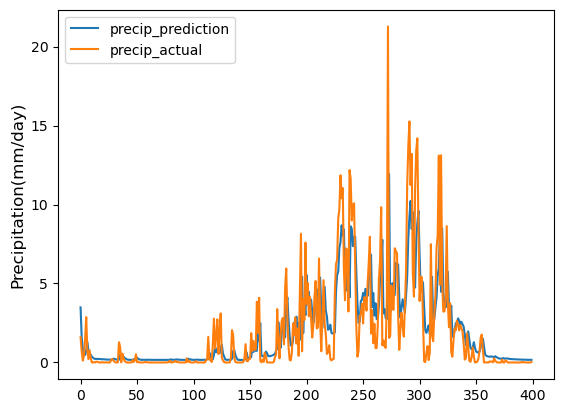

In [30]:
plt.ylabel('Precipitation(mm/day)',fontsize = 12)
plot_predictions(model2, x_test, y_test)

In [31]:
def postprocess_precip(arr):
    arr = (arr * precip_train_std) + precip_train_mean
    return arr

In [32]:
def plot_predictions2 (model2, x, y, start = 600, end = 800):
    prediction = model2.predict(x)
    precip_prediction = postprocess_precip(prediction[:,0])
    precip_actual = postprocess_precip(y[:,])
    df = pd.DataFrame(data = {'Precipitation Prediction': precip_prediction,
                              'Precipitation Actual': precip_actual,
                              })
    plt.plot(df['Precipitation Prediction'][start:end], color = 'green')
    plt.plot(df['Precipitation Actual'][start:end], color = 'red')
    plt.legend(['precip_prediction','precip_actual'],loc=0)
    return df[start:end]

48/48 [==============================] - 0s 818us/step


Text(0.5, 1.0, 'Test Data Comparison for Conv1D')

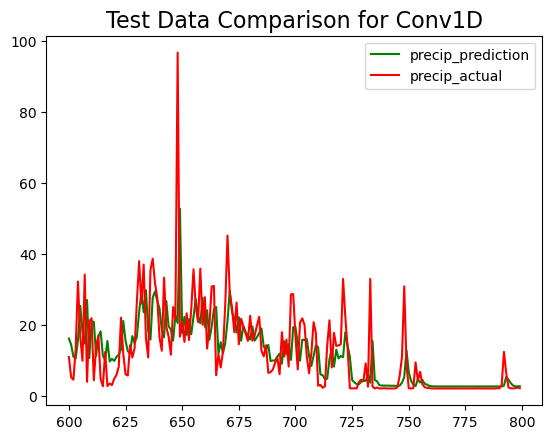

In [33]:
plot_predictions2(model2,x_test,y_test)
plt.title('Test Data Comparison for Conv1D',fontsize = 16)

48/48 [==============================] - 0s 787us/step


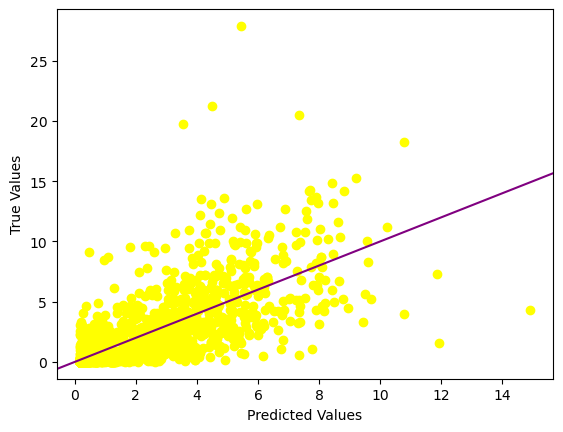

In [34]:
Y_predict = model2.predict(x_test)
plt.scatter(Y_predict, y_test,color = 'yellow')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_=plt.plot([-100,100],[-100,100],color = 'purple')

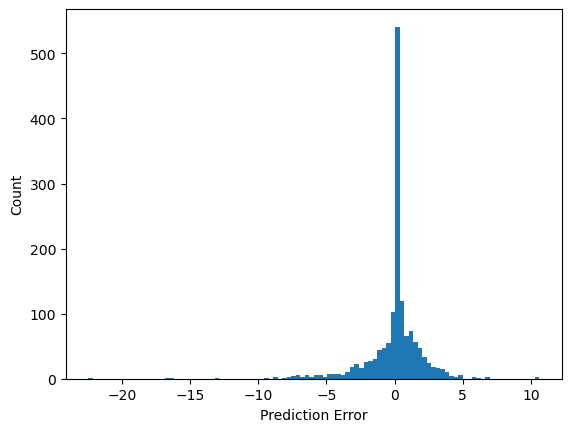

In [35]:
error = Y_predict.reshape(1513,) - y_test
plt.hist(error,bins = 100)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
_=plt.ylabel("Count")

In [36]:
from sklearn.metrics import r2_score
r2_score(y_test,Y_predict)

0.5395683191307112